In [7]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from functions import *

In [8]:
def plot_vector(F_cpu, component_x_cpu, component_y_cpu, skip = 10, vector_length = 60):
    rho_total = np.sum(F_cpu, axis = 0)
    ux = np.sum(F_cpu * component_x_cpu[:, None, None], axis=0) / rho_total
    uy = np.sum(F_cpu * component_y_cpu[:, None, None], axis=0) / rho_total
    speed  = np.sqrt(ux**2 + uy**2)

    x_coords = np.arange(F_cpu.shape[2])
    y_coords = np.arange(F_cpu.shape[1])
    X, Y     = np.meshgrid(x_coords, y_coords)

    # 3. Optional: thin arrows if the grid is very dense
    X, Y, ux, uy = X[::skip, ::skip], Y[::skip, ::skip], ux[::skip, ::skip]*vector_length, uy[::skip, ::skip]*vector_length
    speed_skip = speed[::skip, ::skip]

    # 4. Plot
    fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
    q = ax.quiver(X, Y, uy, ux, speed_skip,              # arrow base- (X,Y) and components (u,v)
                  angles='xy', scale_units='xy', scale=1,   # keep arrow lengths literal
                  width=0.0025, headwidth=3, headlength=4)  # cosmetics

    ax.set_aspect('equal')                    # square pixels → undistorted arrows
    ax.set_xlabel('x index')
    ax.set_ylabel('y index')
    ax.set_title('Velocity field')
    ax.invert_yaxis()

    # 5. (Optional) Draw underlying magnitude as a background image
    # speed = np.hypot(ux, uy)
    # im = ax.imshow(speed, origin='lower', cmap='viridis', alpha=0.4,
    #                extent=[0, nx-1, 0, ny-1])
    # fig.colorbar(im, ax=ax, label='speed')

    plt.tight_layout()
    plt.show()

In [11]:

# initialize grid
'''length_scale = 15
unit_length = 100
nx = ny = length_scale * unit_length
objects = np.zeros((nx, ny), dtype = bool)
objects[30*length_scale:40*length_scale, 35*length_scale:65*length_scale] = True'''

length_scale = 5
unit_length = 100
nx = length_scale * unit_length * 2
ny = length_scale * unit_length
X, Y = np.meshgrid(range(nx), range(ny))

cylinder = ((X-(nx/4))**2 + (Y-(ny/2))**2) < (ny/6)**2
cylinder = cylinder.T

cylinder[:, 0:1] = True
cylinder[:, -2:-1] = True

objects = cylinder

# velocity components
component_x = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])
component_y = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1])
w = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])

# initialize velocity density
F = np.ones((9,nx,ny)) + 0.3*np.random.random((9,nx,ny))
Feq = np.zeros_like(F)
#F[3, :, :] += 0.1
#F[:, objects] = 0
rho_total = np.sum(F, axis = 0)
rho0 = 1
for j in range(9):
    F[j, :, :] *= rho0 / rho_total

# inlet condition
ux_in = 0.16
uy_in = 0.0

# time parameter
tau = 1
t_delta = 1
iterations = 1000

D = ny/3
Re = ux_in * D / ((1/3) * (tau - 0.5))
print("Re = ", Re)

Re =  160.0


  0%|          | 0/1000 [00:00<?, ?it/s]

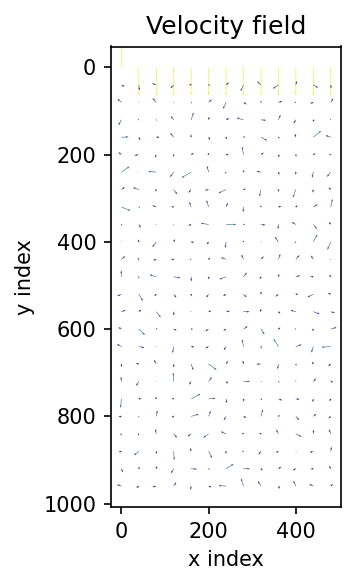

 10%|▉         | 97/1000 [00:00<00:05, 160.79it/s]

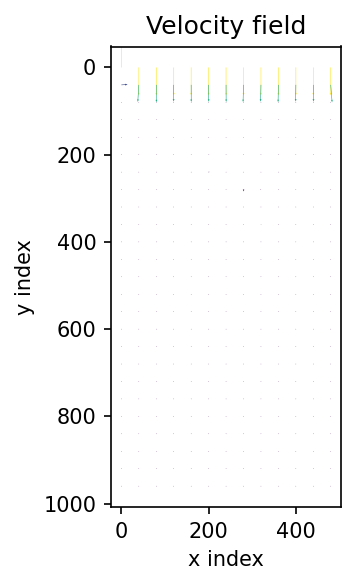

 18%|█▊        | 182/1000 [00:01<00:04, 187.46it/s]

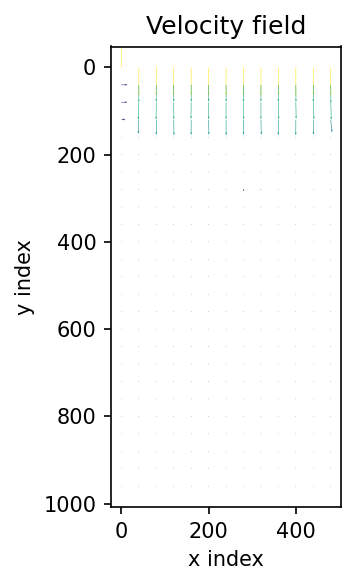

 29%|██▉       | 293/1000 [00:02<00:03, 202.21it/s]

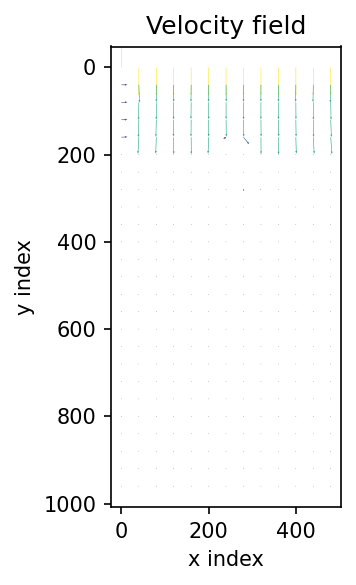

 38%|███▊      | 381/1000 [00:02<00:03, 195.41it/s]

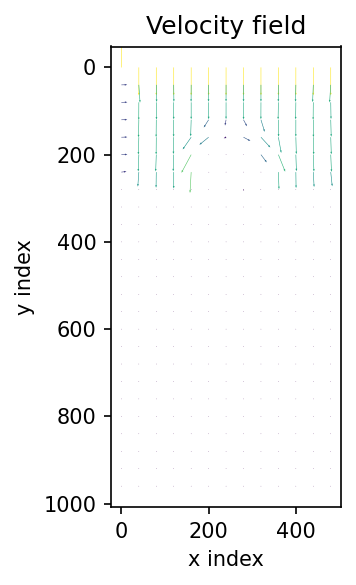

 49%|████▉     | 493/1000 [00:03<00:02, 206.36it/s]

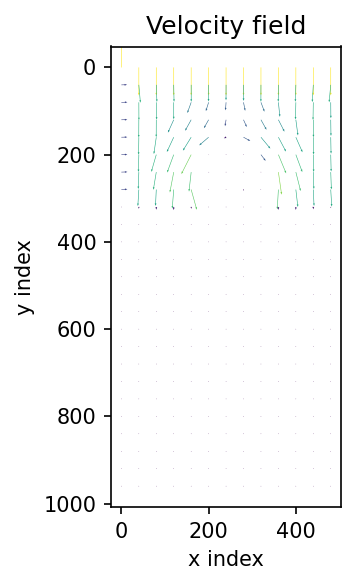

 58%|█████▊    | 582/1000 [00:03<00:02, 196.82it/s]

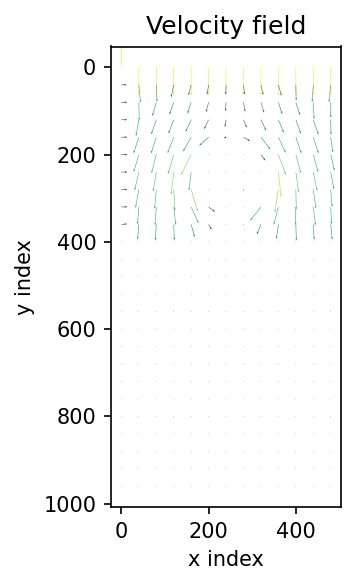

 69%|██████▉   | 691/1000 [00:04<00:01, 202.16it/s]

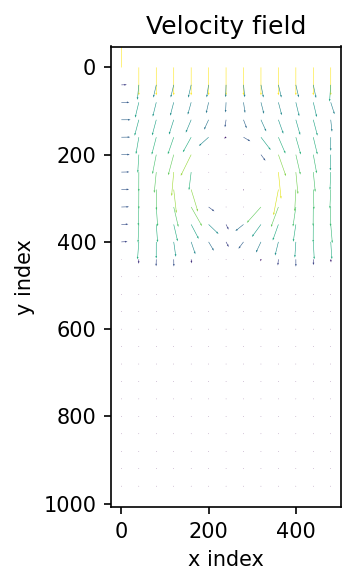

 80%|████████  | 800/1000 [00:04<00:01, 165.07it/s]


KeyboardInterrupt: 

In [12]:

component_x = cp.asarray(component_x)
component_y = cp.asarray(component_y)
w = cp.asarray(w)
F = cp.asarray(F)
objects = cp.asarray(objects)

for i in tqdm(range(iterations)):


    F = flow_drift_CUDA(F, component_x, component_y)

    F = inlet_x_CUDA(F, component_x, component_y, w, ux_in, uy_in, rho0, ny)

    F = collision_equilibrium_CUDA2(F, component_x, component_y, w, t_delta, tau)

    F = boundary_object_CUDA(F, objects)

    '''# objects flow
    inside_boundary = F[:, objects]
    inside_boundary = inside_boundary[[0,5,6,7,8,1,2,3,4], :]
    F[:, objects] = inside_boundary'''

    if i%100==0:
        F_cpu = cp.asnumpy(F)
        component_x_cpu = cp.asnumpy(component_x)
        component_y_cpu = cp.asnumpy(component_y)
        objects_cpu = cp.asnumpy(objects)
        #plot_velocity(F_cpu, component_x_cpu, component_y_cpu)
        #plot_vorticity(F_cpu, component_x_cpu, component_y_cpu, objects_cpu)
        plot_vector(F_cpu, component_x_cpu, component_y_cpu, skip = 8*length_scale, vector_length = 80*length_scale)
